# Azure Computer Vision Using Python SDK

# Objective:

This file intends to introduce the learners to the Custom Vision Service offered by Azure, through the means of Python SDK. We will create a custom vision resource in Azure, but the rest of the tasks related to image analysis will be conducted by way of Python SDK for Azure Custom Vision.

For the purpose of this session, we will analyse images stored in local system. There is one more way to analyse images, which is to read them remotely through the url.

We would encourage you to try improving the performance of the model.

Dataset: Boats Dataset

Dataset information: This dataset contains 621 images of 1 class for the objective of ship detection. Bounding box annotations are provided in the PASCAL VOC format in XML files, one per image.

The original dataset has been preprocessed in Kaggle as per the following steps:
1. It has been split into train and test datasets.
2. The files have been preprocessed to create one csv file each for test and train sets.
3. The associated csv files have the bounding box information for each image. The bounding box information was originally present as width, height, xmin, ymin, xmax, ymax. As the bounding box information was present in Pascal VOC format, it has been normalised using the follwing formula:
  * xmin_normalised = xmin/width
  * width_normalised = (xmax - xmin)/width
  * ymin_normalised = ymin/height
  * height_normalised = (ymax - ymin)/height


  The goal is to create an object detection model that can create a bounding box around a ship.

The data has been downloaded from this source: https://www.kaggle.com/datasets/andrewmvd/ship-detection

To learn more about preparing the dataset for object detection, i.e. how to manually identify the bounding box region, and how to extract the coordinates from the XML file, please refer to this notebook on Kaggle:

https://www.kaggle.com/code/aslanahmedov/automatic-number-plate-recognition#2.4-PARSING-DATA-FROM-XML-AND-CONVERTING-IT-INTO-CSV

## Prerequisites

Installing library to read environment variables.

In [1]:
!pip install python-dotenv

Installing library to enable access to the Azure custom vision service

In [2]:
!pip install azure-cognitiveservices-vision-customvision

  Obtaining dependency information for azure-cognitiveservices-vision-customvision from https://files.pythonhosted.org/packages/c5/50/6d7840c59f45123a5c1cb9c935dcac614f0ca7be49cf1bf584e7a4cdbf4a/azure_cognitiveservices_vision_customvision-3.1.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.8 MB/s eta 0:00:00


## Importing necessary libraries

In [1]:
# to connect to the training resource
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient

# to connect to the prediction resource
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient

# to send the input files in batch; and to identify the object regions; for the training of the model.
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region

# To authenticate the client
from msrest.authentication import ApiKeyCredentials
import os, uuid

# To read the local environment variables and secret keys
import os, dotenv
from dotenv import load_dotenv, find_dotenv

# To read the dataset
import pandas as pd

# to view images
from IPython.display import Image as img

# to process data in batches
import itertools

# to draw bounding boxes in local output.
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

/Users/uday/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Connecting to the Azure Custom Vision Service

## Step 1: Create an Azure Custom Vision resource on the Azure Portal.

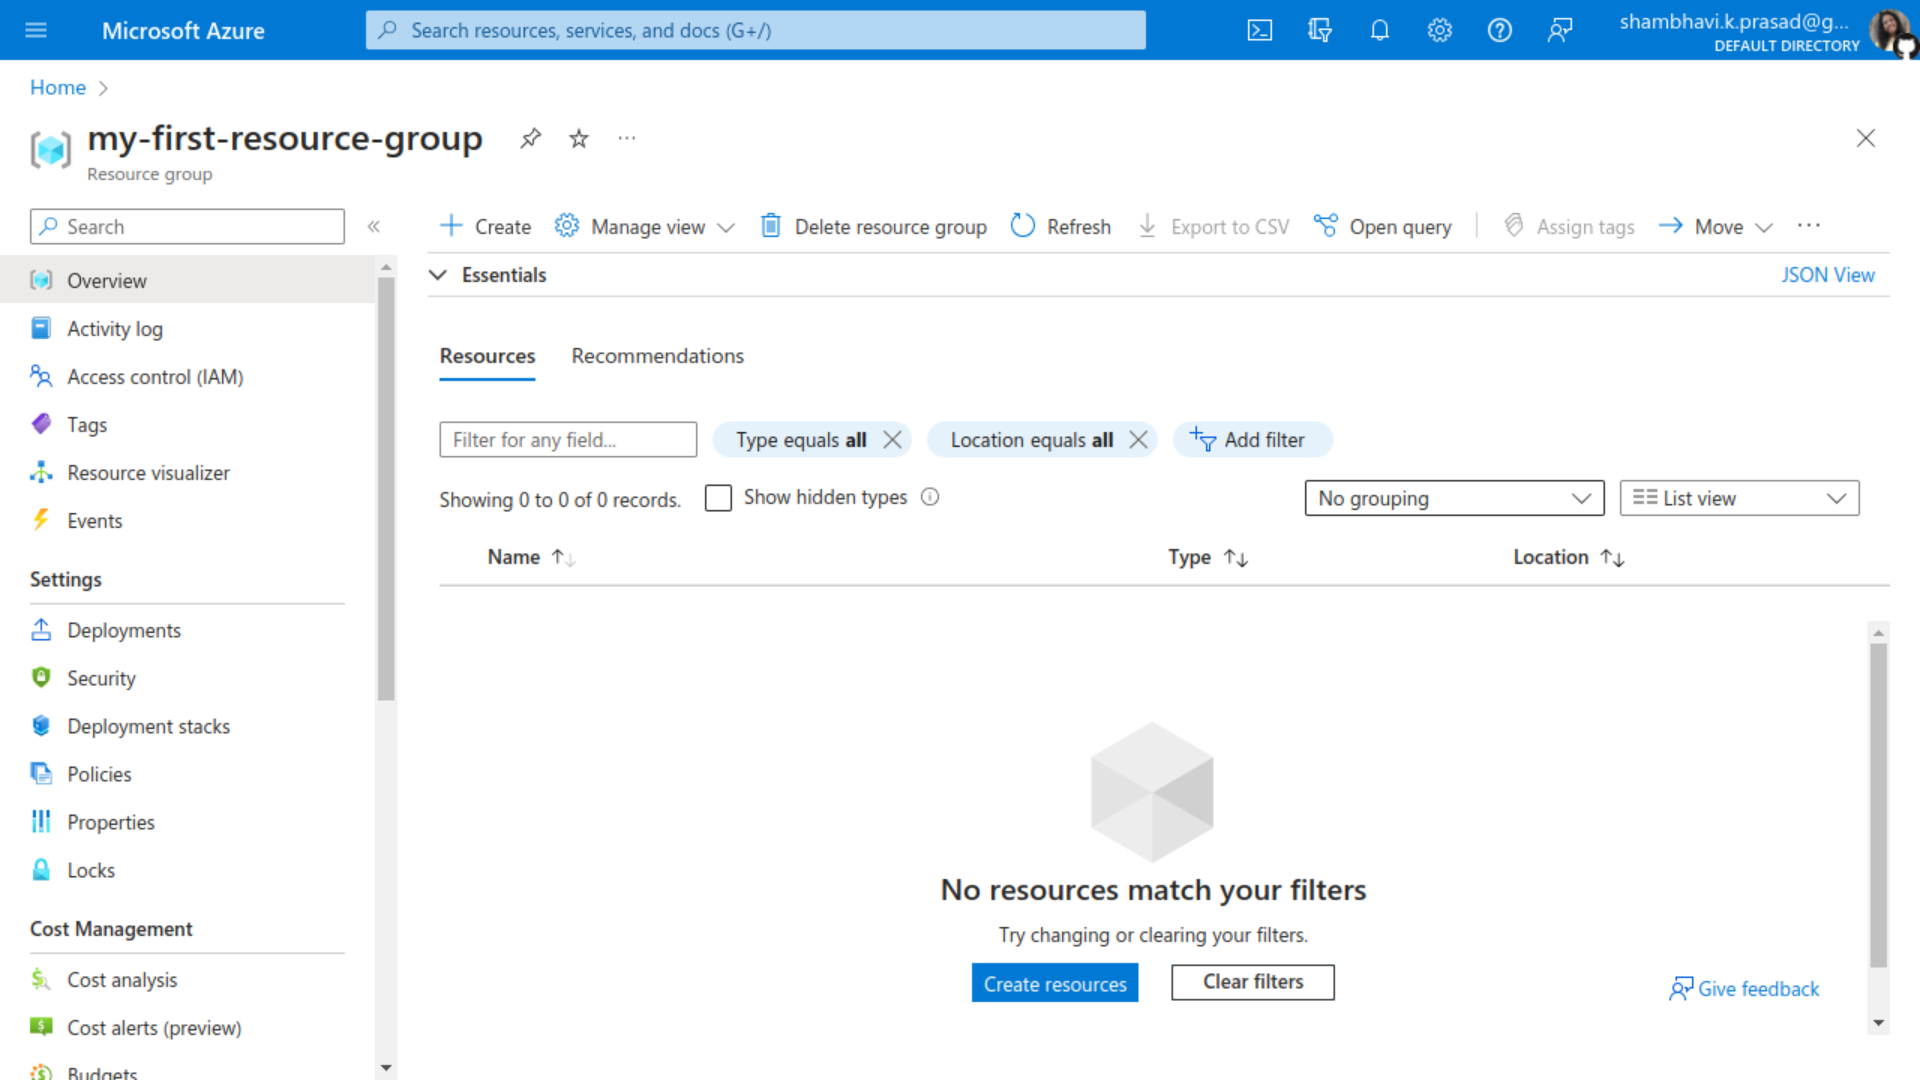

In [ ]:
img('cv1.png')

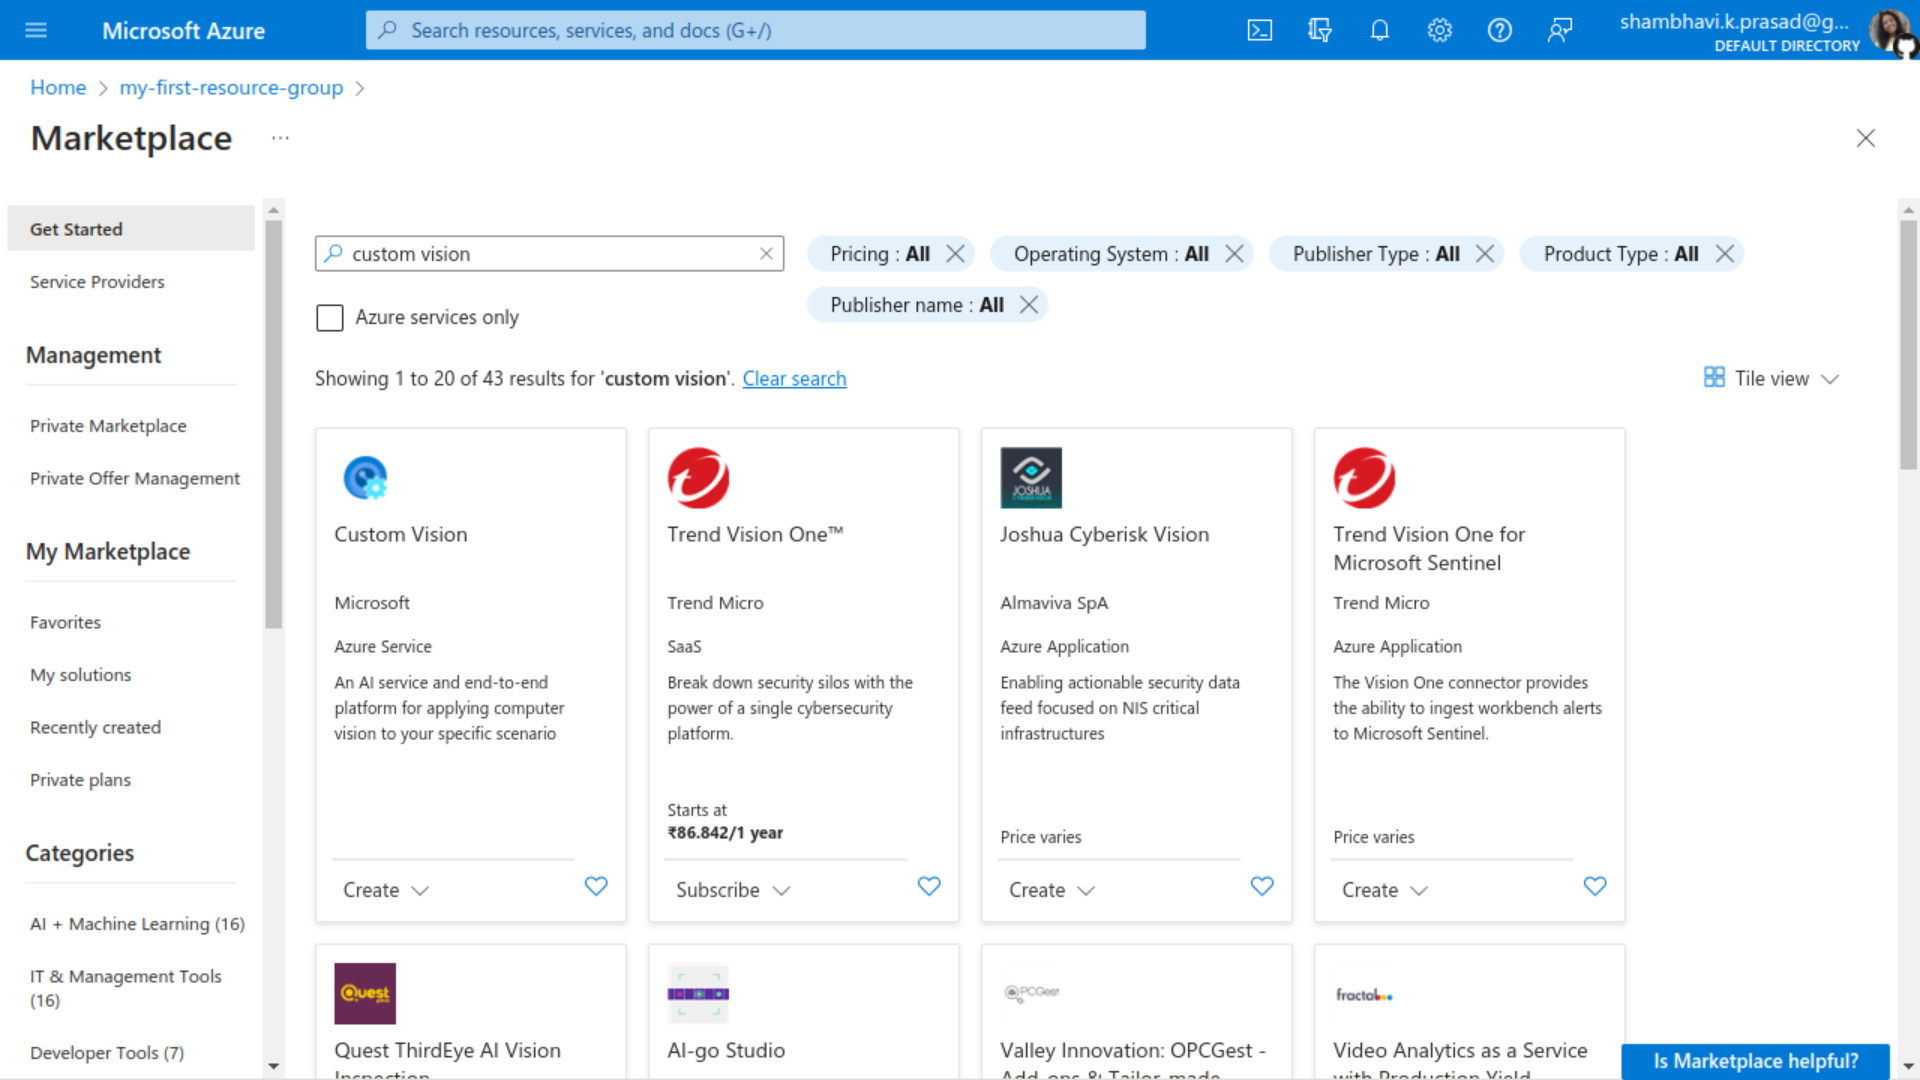

In [ ]:
img('cv2.png')

## Please select both Training and Prediction resources to be created.

 * Please select the free pricing tier for both the resources.

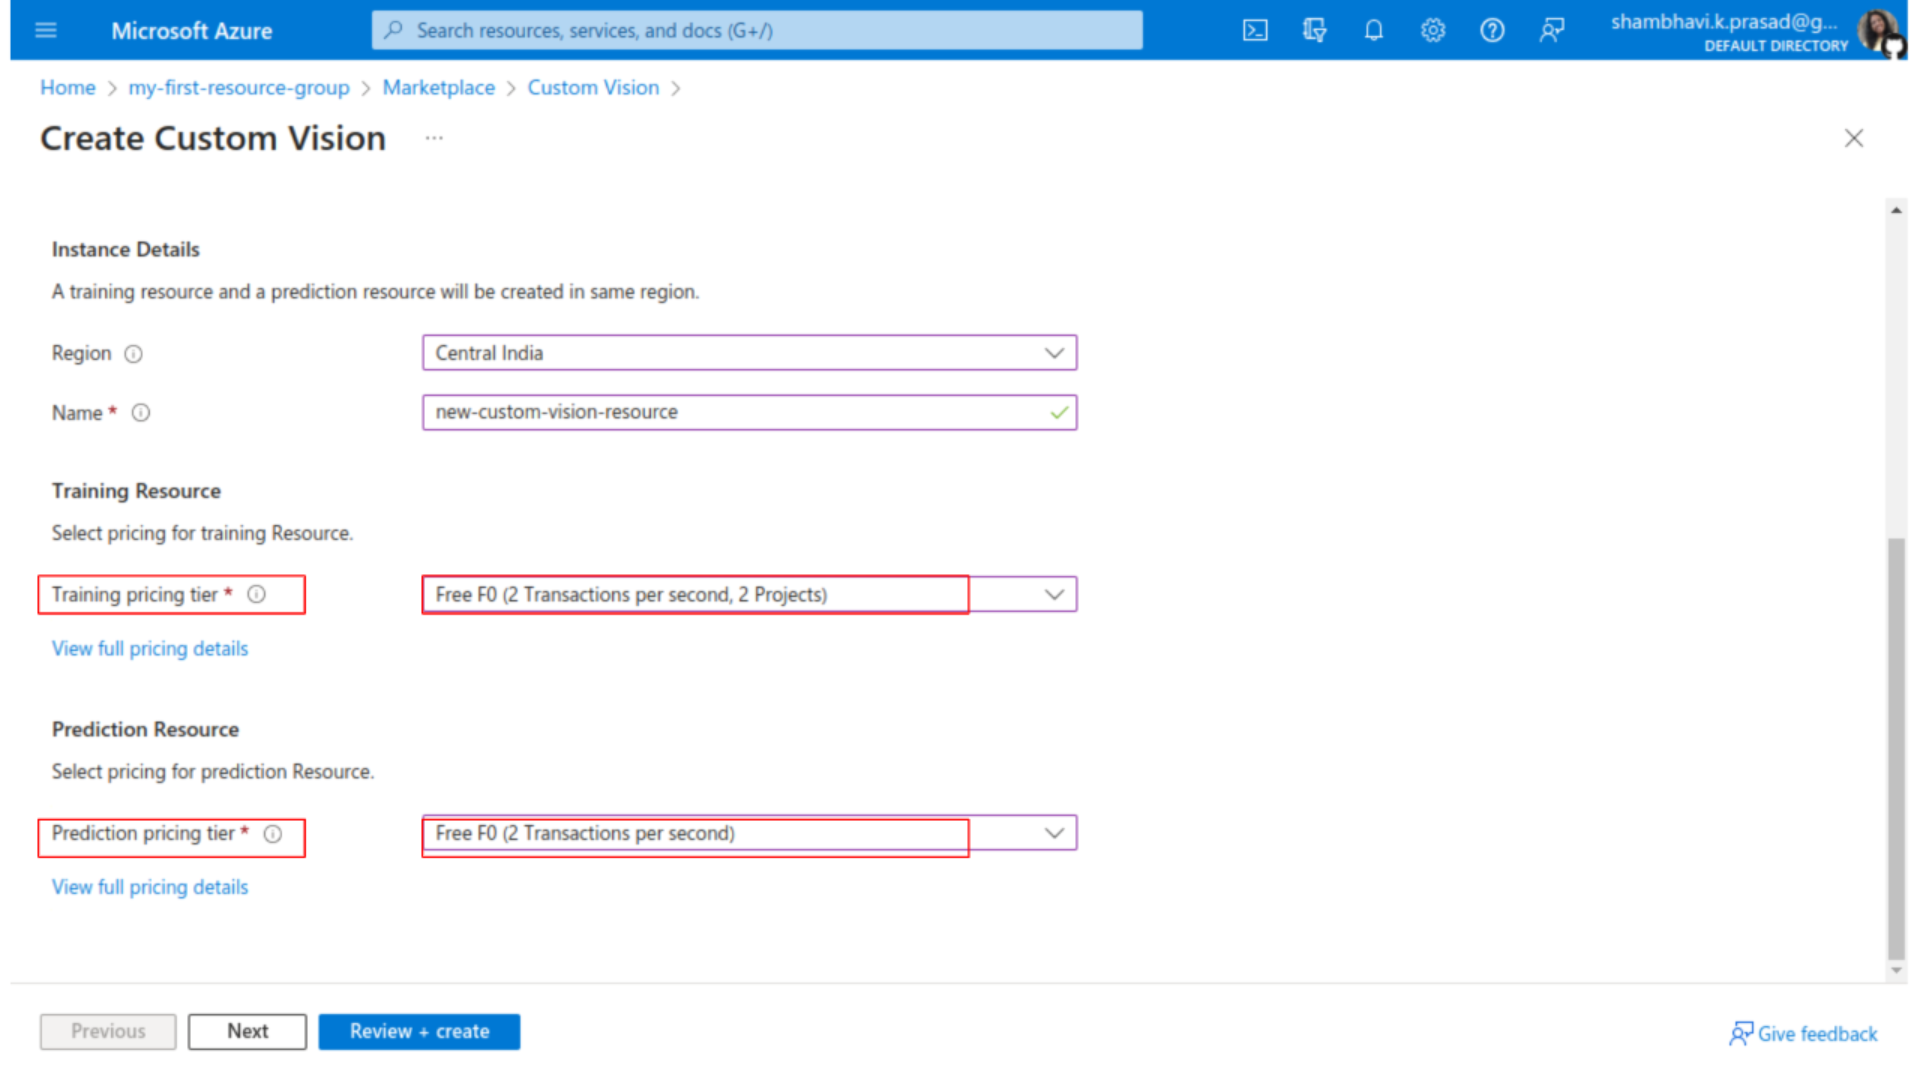

In [ ]:
img('cv3.png')

## Output: A Custom Vision Training and Prediction resource will be created.

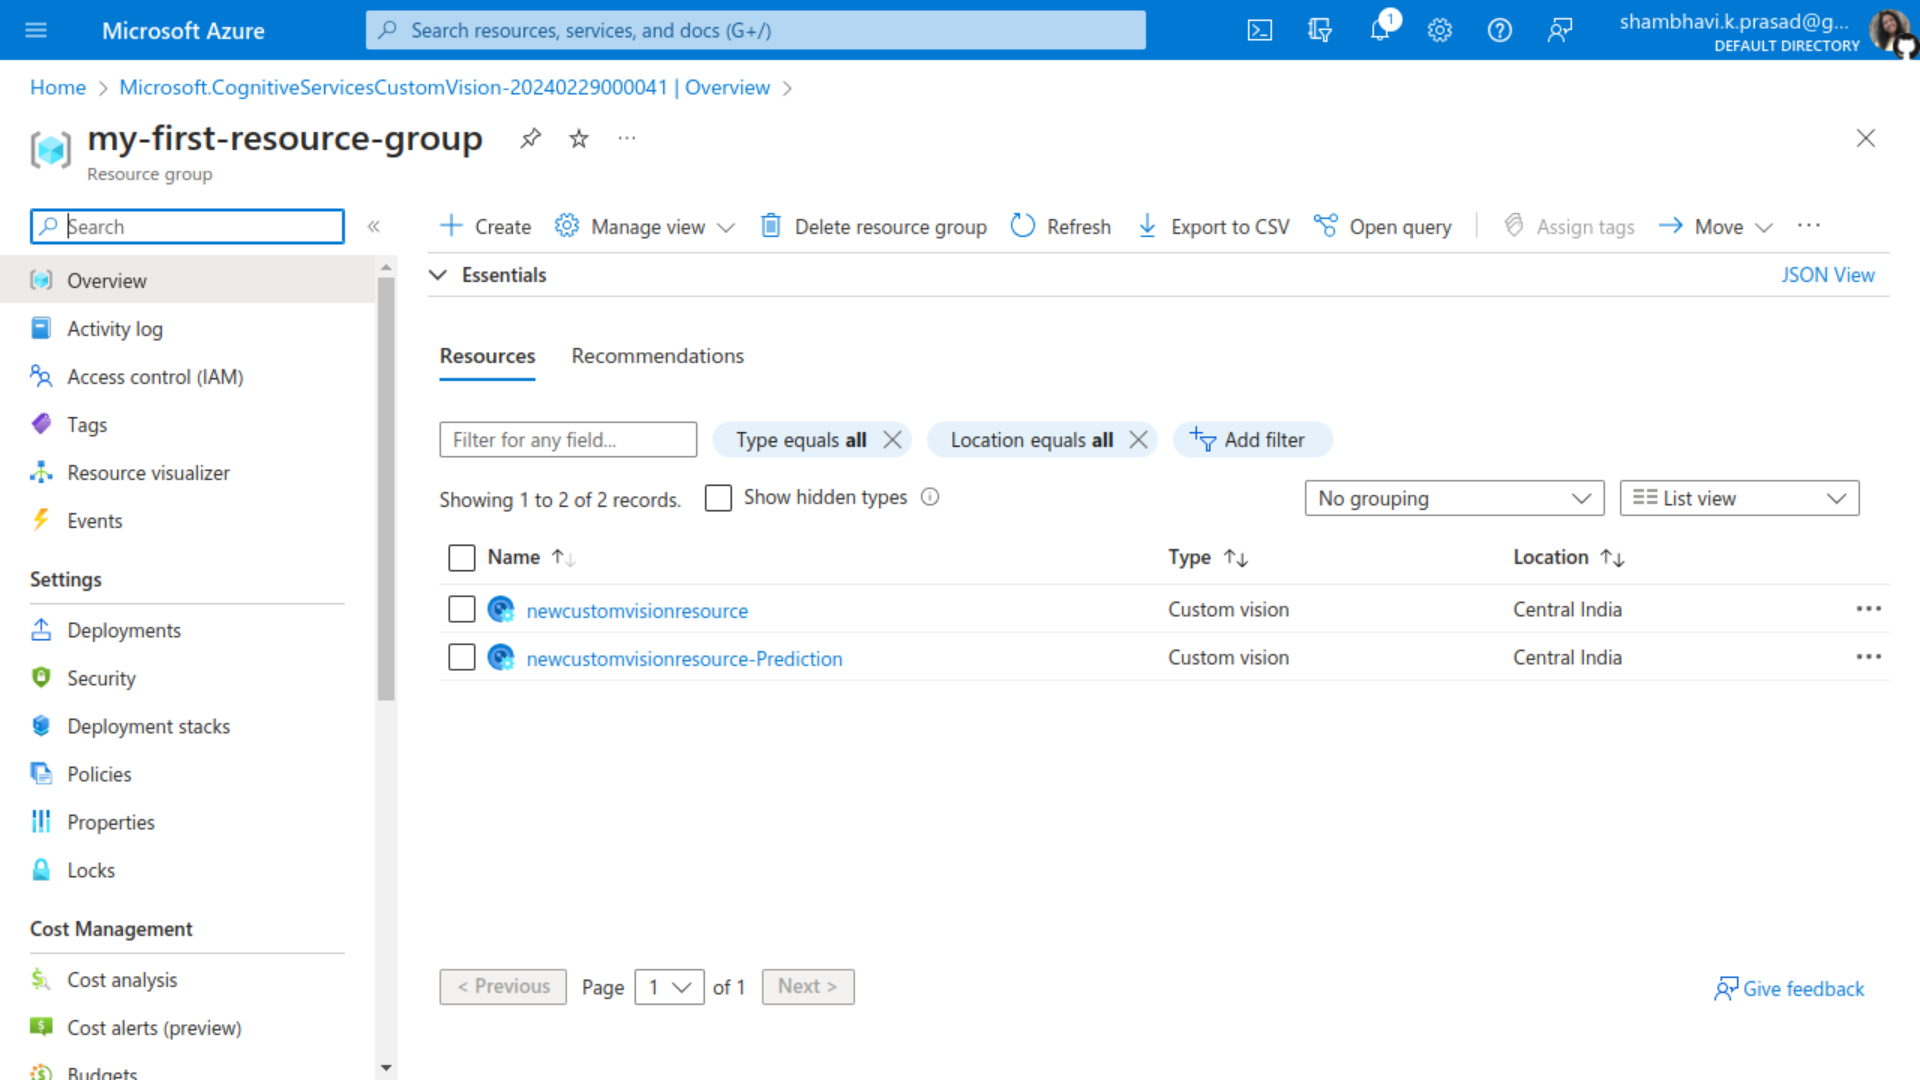

In [ ]:
img('cv4.png')

## Create an environment file (.env) and save it in the current working directory.
### We will replace the placeholder values, as described below.


VISION_TRAINING_ENDPOINT= <'your_training_endpoint'></br>
VISION_TRAINING_KEY= <'your_training_key'></br>
VISION_TRAINING_ENDPOINT= <'your_prediction_endpoint'></br>
VISION_PREDICTION_KEY= <'your_prediction_key'></br>
VISION_PREDICTION_RESOURCE_ID= <'your_prediction_resource_ID'>

## How to populate your .env file:
1. Go to https://www.customvision.ai/projects#/settings

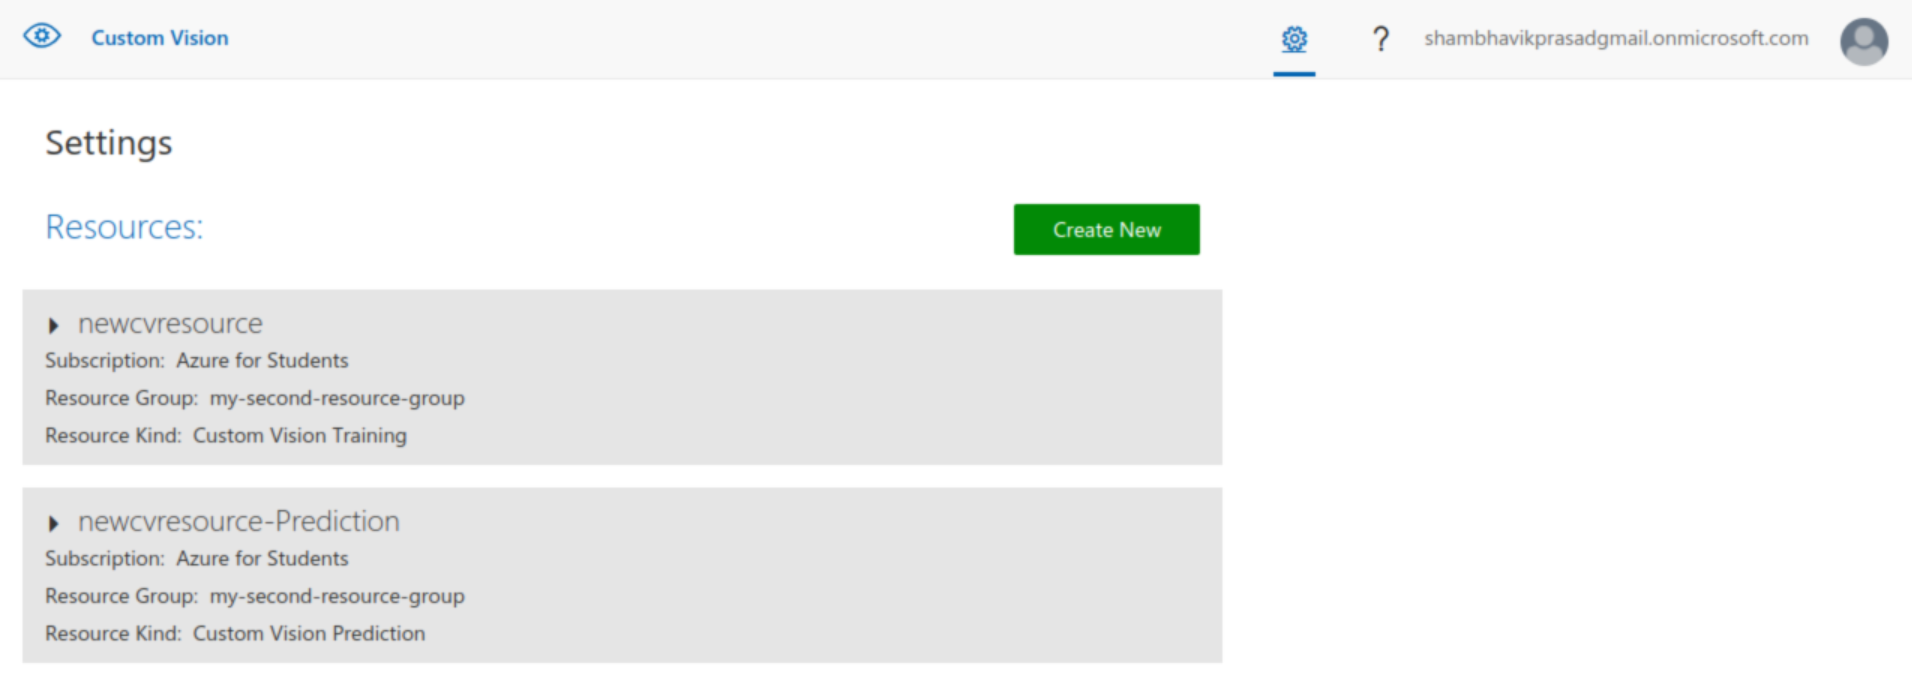

In [ ]:
img('cv_alt1.png')

2. Expand the training resource section.
3. Copy the key and endpoint for the training resource and save the corresponding variables in the .env file.

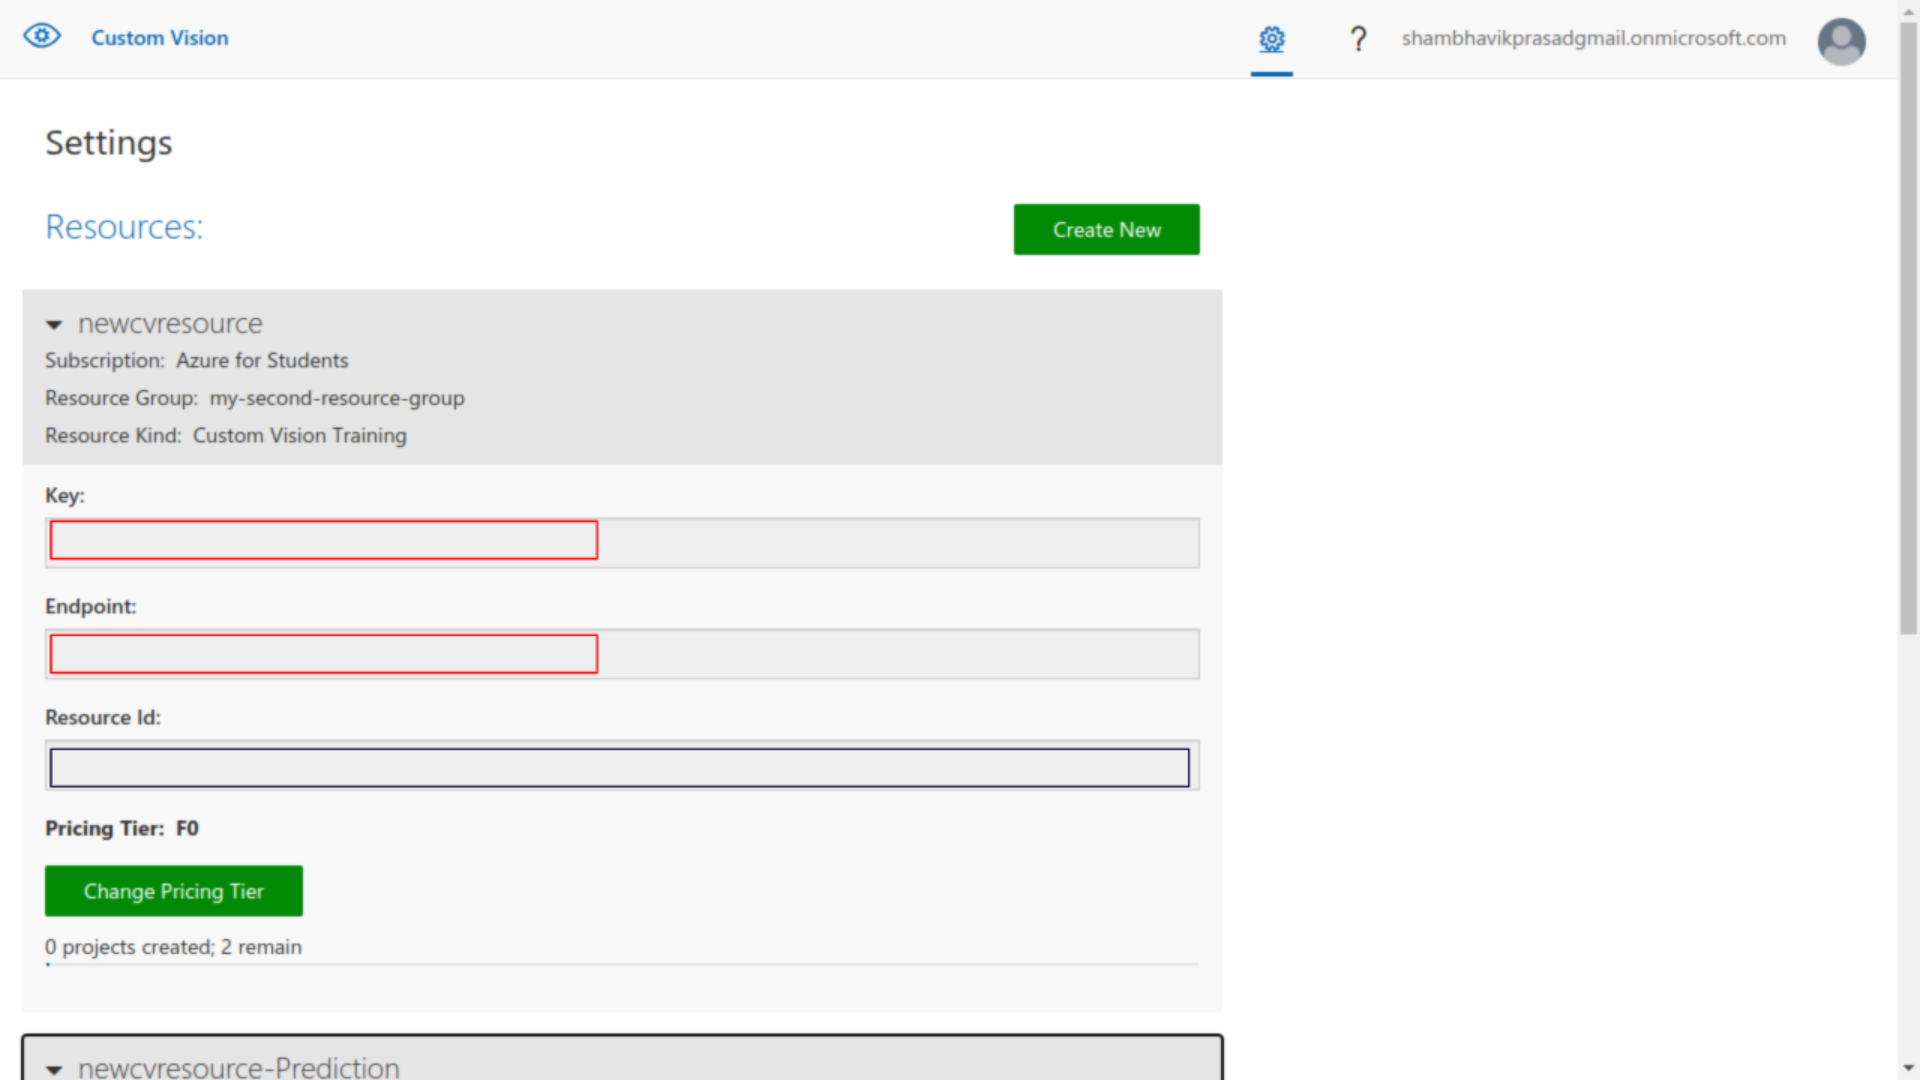

In [ ]:
img('cv_alt2.png')

4. Expand the prediction resource section.
5. Copy the key and resourceID for the prediction resource and save the corresponding variables in the .env file.

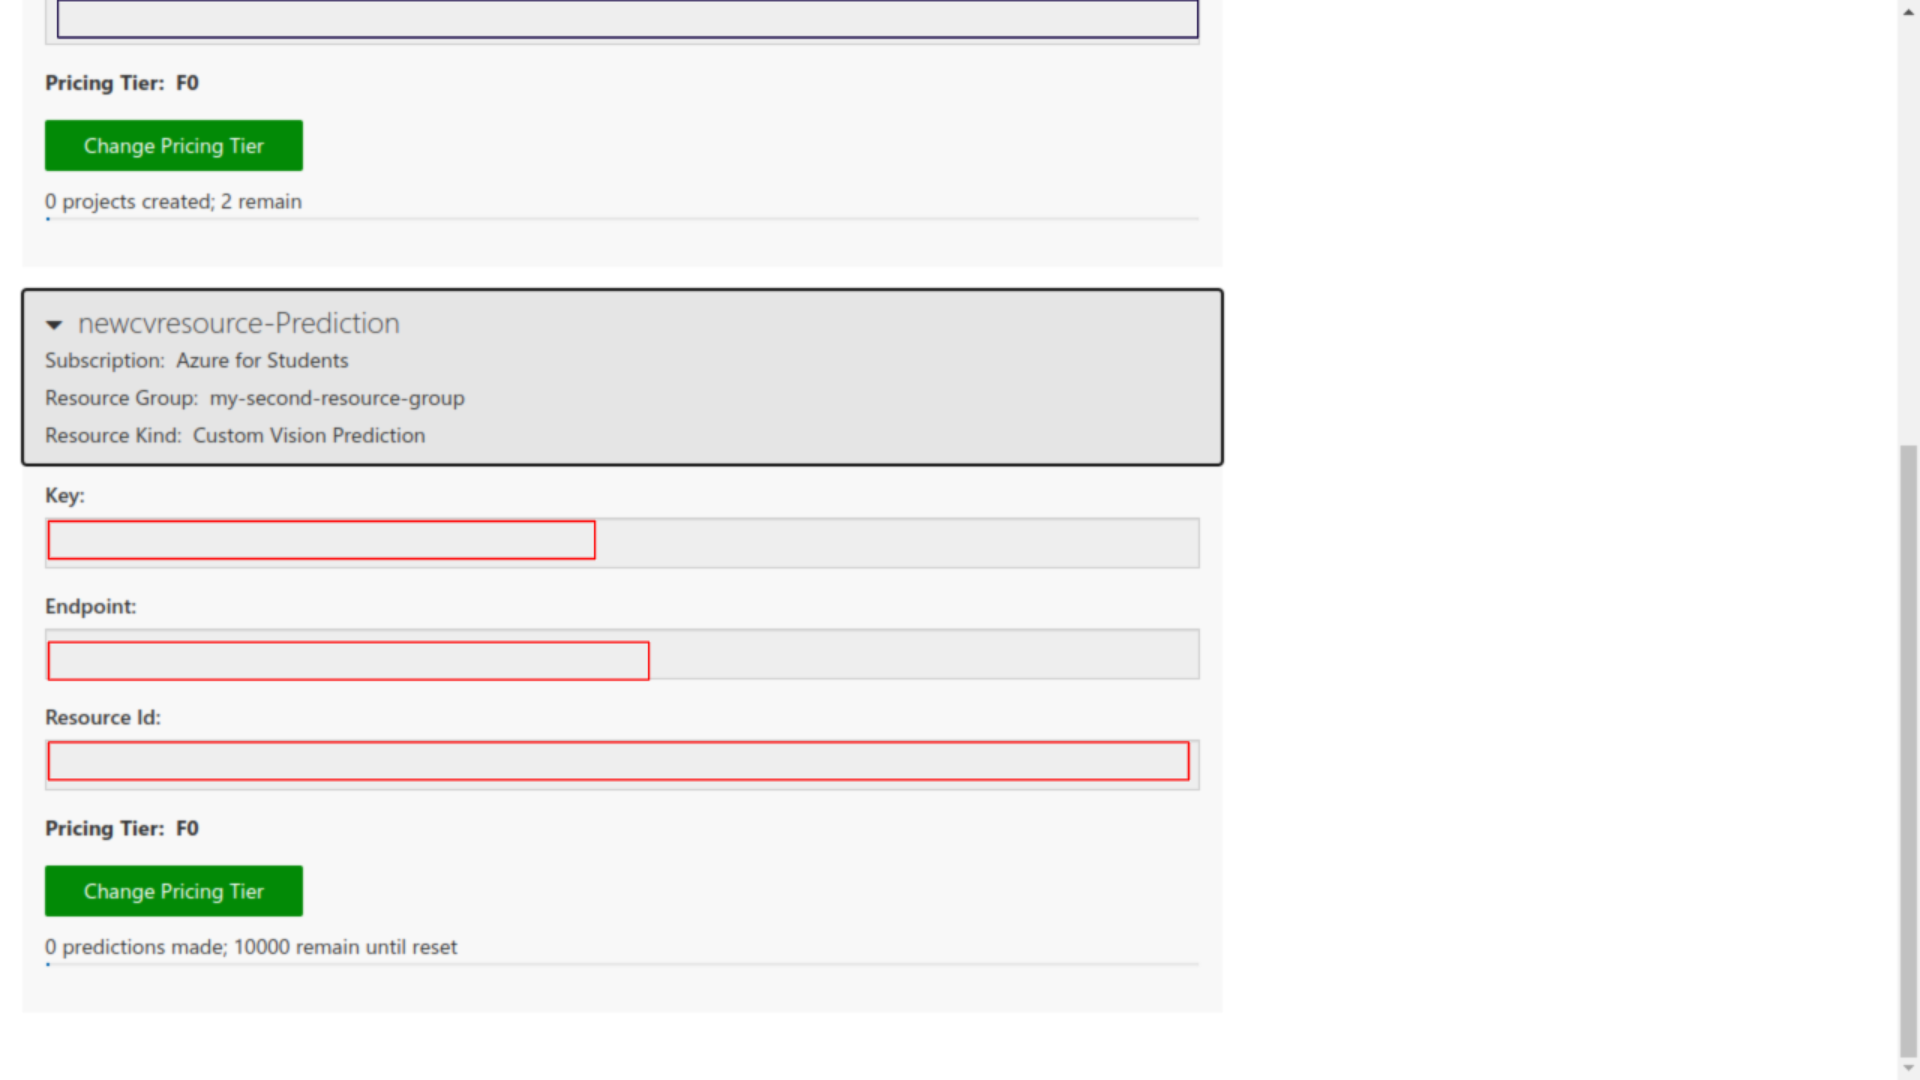

In [ ]:
img('cv_alt3.png')

## Connect to the Custom Vision Service

In [2]:
# Read the environment file to access your secret keys
load_dotenv('customvision.env')

# Replace with valid values
VISION_TRAINING_ENDPOINT = os.environ["VISION_TRAINING_ENDPOINT"]
training_key = os.environ["VISION_TRAINING_KEY"]
prediction_key = os.environ["VISION_PREDICTION_KEY"]
prediction_resource_id = os.environ["VISION_PREDICTION_RESOURCE_ID"]
VISION_PREDICTION_ENDPOINT= os.environ["VISION_PREDICTION_ENDPOINT"]

In [3]:
# create variables for your training resource
credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(VISION_TRAINING_ENDPOINT, credentials)

# create variables for your prediction resource
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-Key": prediction_key})
predictor = CustomVisionPredictionClient(VISION_PREDICTION_ENDPOINT, prediction_credentials)

publish_iteration_name = "detect_ship"

# Find the object detection domain
obj_detection_domain = next(domain for domain in trainer.get_domains() if
                           domain.type == "ObjectDetection" and domain.name == "General")

# Create a new project
print("Creating project...")
# Use uuid to avoid project name collisions.
project = trainer.create_project(publish_iteration_name,
                                domain_id=obj_detection_domain.id)

# Make two tags in the new project
ship_tag = trainer.create_tag(project.id, "ship")

Creating project...


In [27]:
predictor

## To view your project, go to https://www.customvision.ai/projects

* You should see your project created there. If not, try refreshing the page by clicking on the Custom Vision tab at the upper left corner.

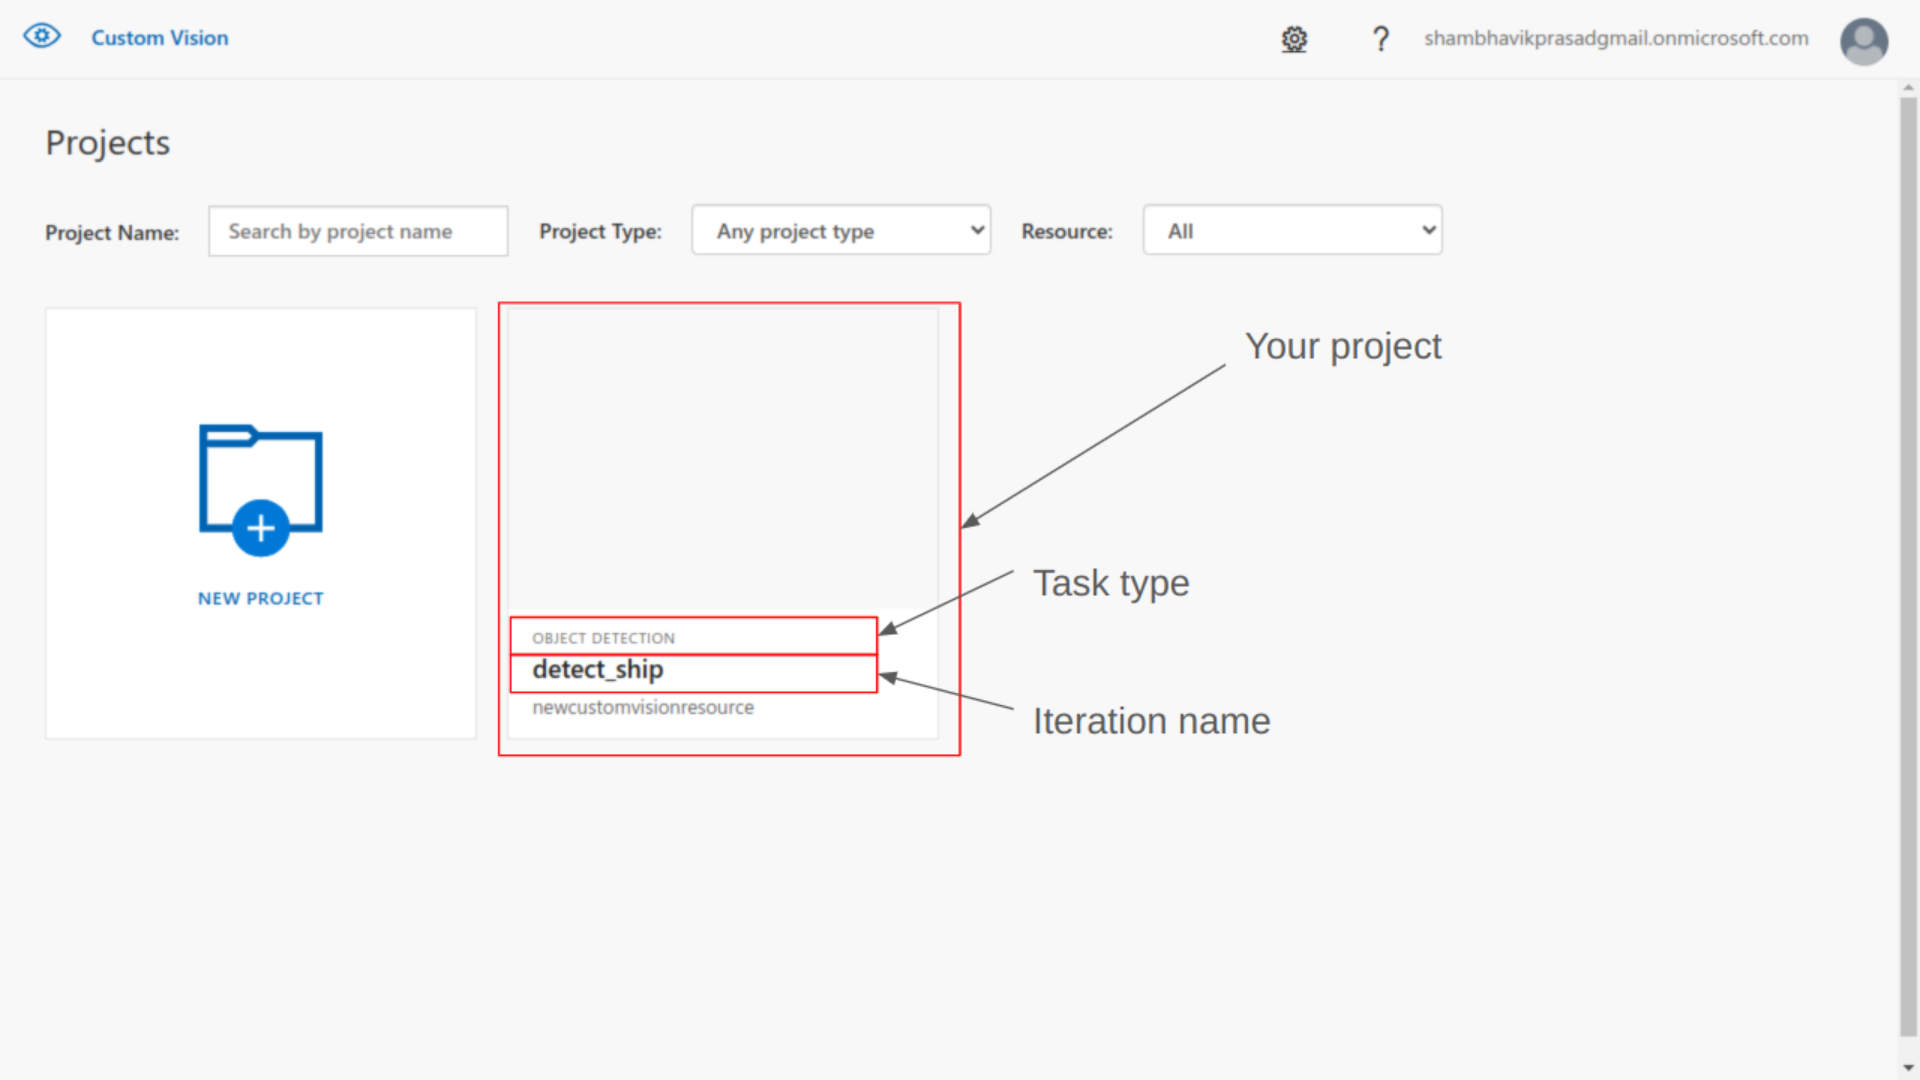

In [ ]:
img('cv10.png')

### The project has been created, but it is empty. We need to populate it with images and their respective tags along with the bounding box coordinates, to train the model. In this case study, we will upload these data points through the Python SDK.

## Dataset preparation

* We need to read the train data annotations, and prepare it for uploading to our project.

In [4]:
# Read the train dataset
train_data = pd.read_csv('annotation_train.csv')

In [5]:
# checking the train dataset
train_data.head(5)

filename obj_name  width  height  xmin  ymin  xmax  ymax  xmin_norm  \
0  boat435.png     boat    502     476    48   193   148   296   0.095618   
1  boat113.png     boat    352     262   185   144   224   195   0.525568   
2  boat367.png     boat    400     365   163   144   182   191   0.407500   
3  boat447.png     boat    380     352   189   210   207   241   0.497368   
4  boat447.png     boat    380     352   218   218   243   265   0.573684   

   y_min_norm  width_norm  height_norm  
0    0.384462    0.199203     0.216387  
1    0.409091    0.110795     0.194656  
2    0.360000    0.047500     0.128767  
3    0.552632    0.047368     0.088068  
4    0.573684    0.065789     0.133523

In [30]:
train_data.columns

Index(['filename', 'obj_name', 'width', 'height', 'xmin', 'ymin', 'xmax',
       'ymax', 'xmin_norm', 'y_min_norm', 'width_norm', 'height_norm'],
      dtype='object')

In [6]:
# We need the region information for each image in a dictionary in the following format:
# key  = image name
# values = [xmin_normalised, y_min_normalised, width_normalised, height_normalised]

# In our train and test datasets, we have these data points. So, we will read each row of the dataframe, then add the values listed above, to a dictionary.
# We will use this dictionary of regions to train our model.

# creating a new dictionary to store our region data for each image.
image_regions = {}

# iterate through the dataset row by row
for index, row in train_data.iterrows():

    # read the values for filename, xmin_norm, ymin_norm, width_norm and height_norm for each row and save in new variables for each value.
    filename = row["filename"]
    xmin_norm = row["xmin_norm"]
    ymin_norm = row["xmin_norm"]
    width_norm = row["width_norm"]
    height_norm = row["height_norm"]

    # update the dictioary with the key as the image name (which is the filename without the extension)
    # the values define the bounding box region.
    image_regions[filename.strip('.png')] = [xmin_norm, ymin_norm, width_norm, height_norm]

## Upload images to the project:

As Azure places a limit of 64 entries at a time, we need to slice our train data into batches of 64 images and upload those.

In [7]:
base_image_location = "/Users/uday/Library/CloudStorage/OneDrive-Personal/Documents/Jupyter Notebooks/GREATLEARNING/MASTER DS/ENGINEERING AI SOLUTIONS/NEW FILES/WEEK 4_CV/ship_pics"

In [8]:
# to slice the data in batches of 64, we will use the islice method of itertools as the data for images bounding boxes is stored in a dictionary.
# we will specify start and stop indices for our slice. To specify a new slice, we just need to update the start index.
start = 0
stop = start + 64
image_regions_batch  = dict(itertools.islice(image_regions.items(), start, stop))

In [9]:
image_regions_batch

{'boat435': [0.0956175298804781,
  0.0956175298804781,
  0.199203187250996,
  0.216386554621849],
 'boat113': [0.525568181818182,
  0.525568181818182,
  0.110795454545455,
  0.194656488549618],
 'boat367': [0.4075, 0.4075, 0.0475, 0.128767123287671],
 'boat447': [0.573684210526316,
  0.573684210526316,
  0.0657894736842105,
  0.133522727272727],
 'boat7': [0.64, 0.64, 0.0375, 0.0452674897119342],
 'boat161': [0.33206106870229, 0.33206106870229, 0.066793893129771, 0.3125],
 'boat158': [0.5, 0.5, 0.264248704663212, 0.243386243386243],
 'boat82': [0.377470355731225,
  0.377470355731225,
  0.0790513833992095,
  0.0982532751091703],
 'boat623': [0.368055555555556,
  0.368055555555556,
  0.0810185185185185,
  0.131840796019901],
 'boat211': [0.174216027874564,
  0.174216027874564,
  0.141114982578397,
  0.139097744360902],
 'boat413': [0.655487804878049, 0.655487804878049, 0.13109756097561, 0.071875],
 'boat239': [0.364035087719298,
  0.364035087719298,
  0.212719298245614,
  0.2651162790697

In [10]:
# Go through the data table above and create the images
print("Adding images...")
tagged_images_with_regions = []

for file_name in image_regions_batch.keys():
    x, y, w, h = image_regions_batch[file_name]
    regions = [
        Region(tag_id=ship_tag.id, left=x, top=y, width=w, height=h)]

    with open(
            os.path.join(base_image_location, file_name + ".png"),
            mode="rb") as image_contents:
        tagged_images_with_regions.append(
            ImageFileCreateEntry(name=file_name,
                                  contents=image_contents.read(),
                                  regions=regions))

upload_result = trainer.create_images_from_files(project.id,
                                                  ImageFileCreateBatch(
                                                      images=tagged_images_with_regions))

if not upload_result.is_batch_successful:
    print("Image batch upload failed.")
    for image in upload_result.images:
        print("Image status: ", image.status)
    exit(-1)

Adding images...
Image batch upload failed.
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  ErrorInvalidRegion
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Imag

## After all your training images have been added, you can see them in the Custom Vision Studio as well.

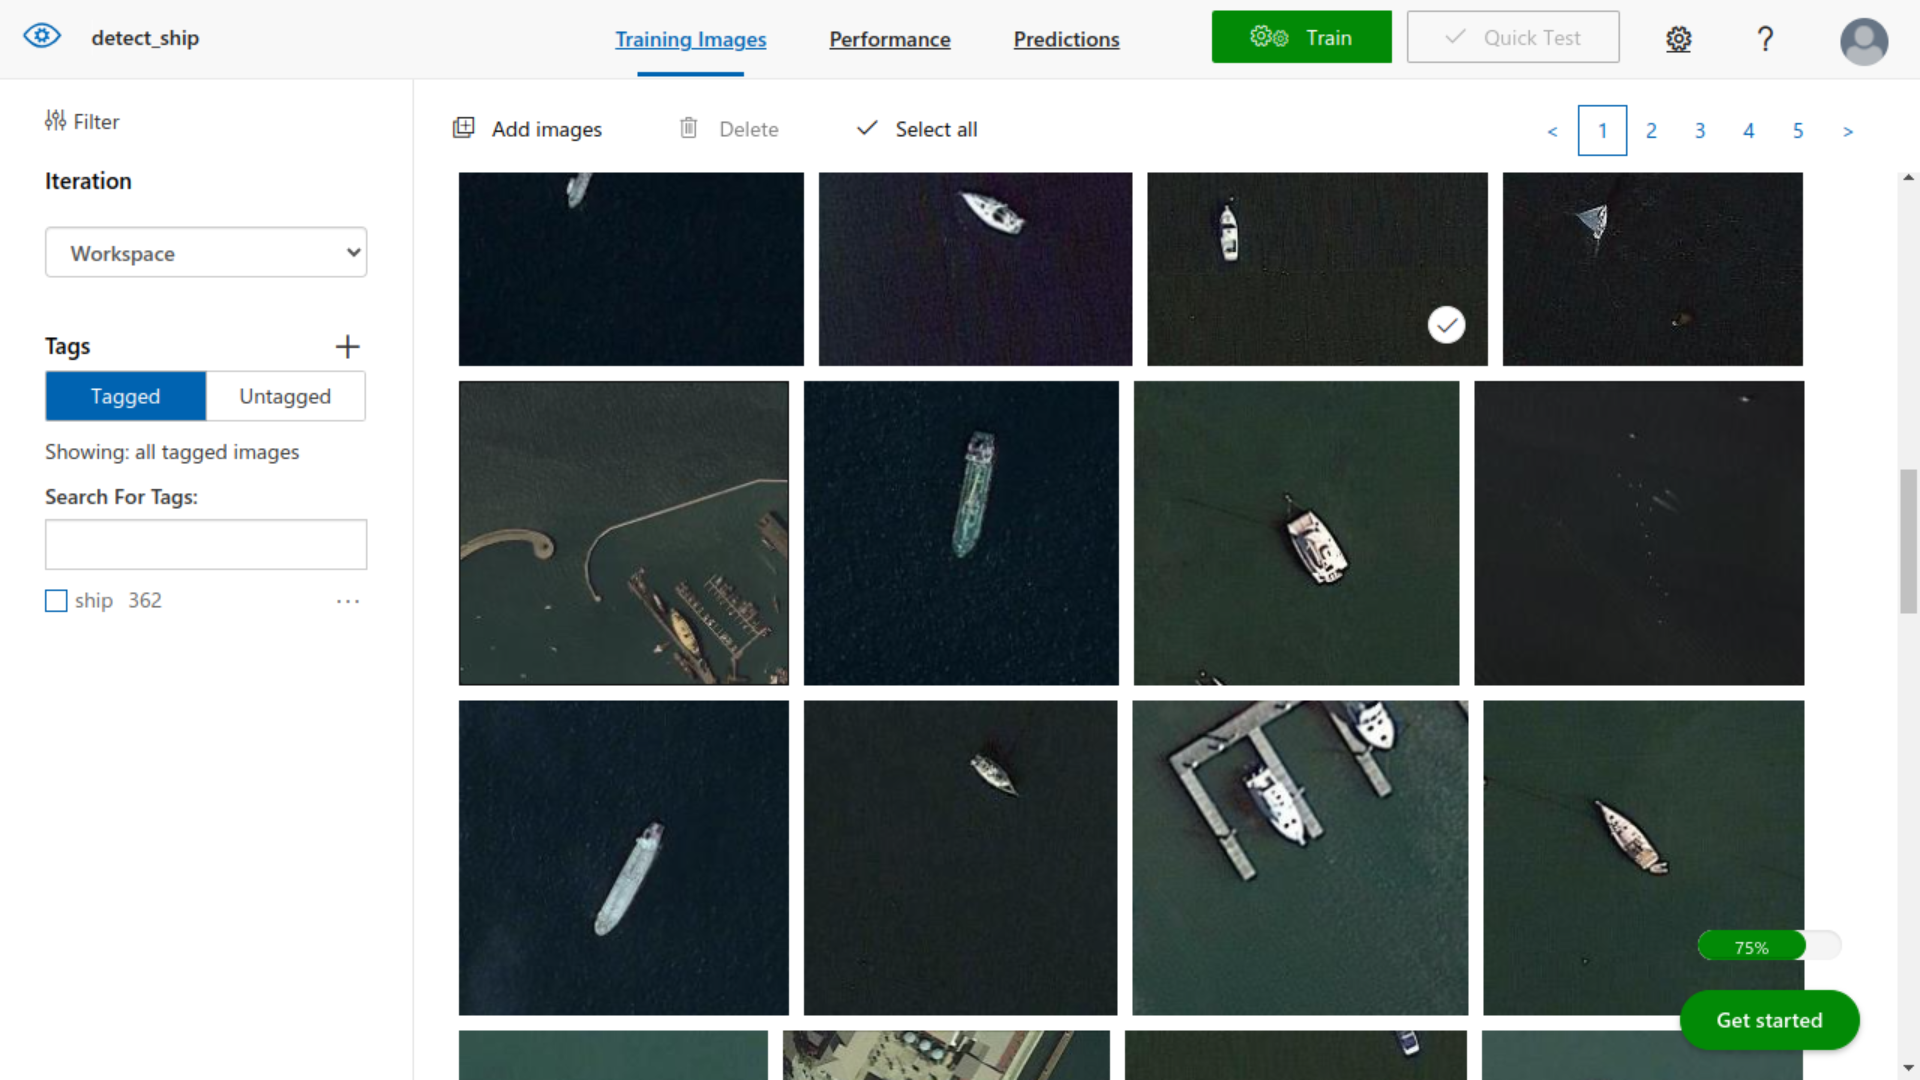

In [ ]:
img('cv11.png')

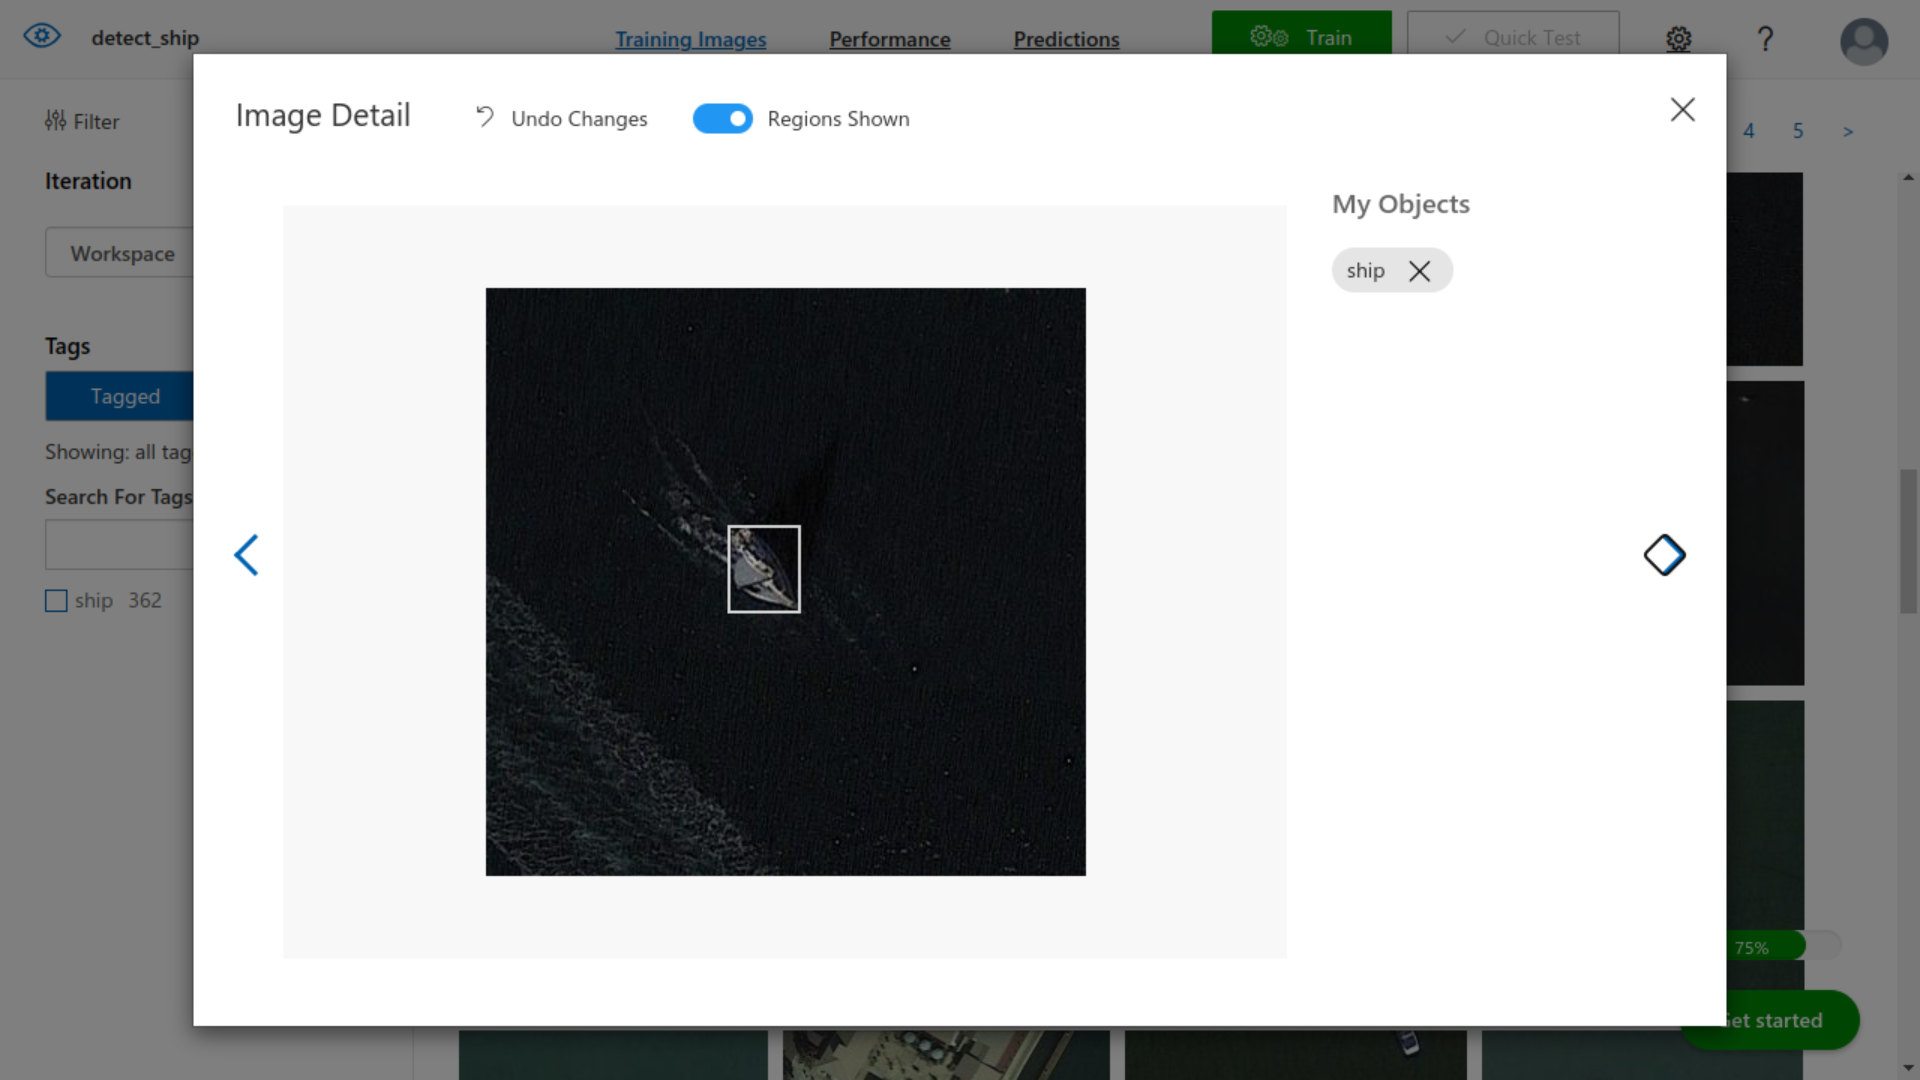

In [ ]:
img('cv12.png')

## Training the model

In [11]:
import time

print ("Training...")
iteration = trainer.train_project(project.id)
while (iteration.status != "Completed"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    time.sleep(1)

Training...
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training


## After the training is completed, you can view the performance of the model by clicking on the 'Performance'  tab.

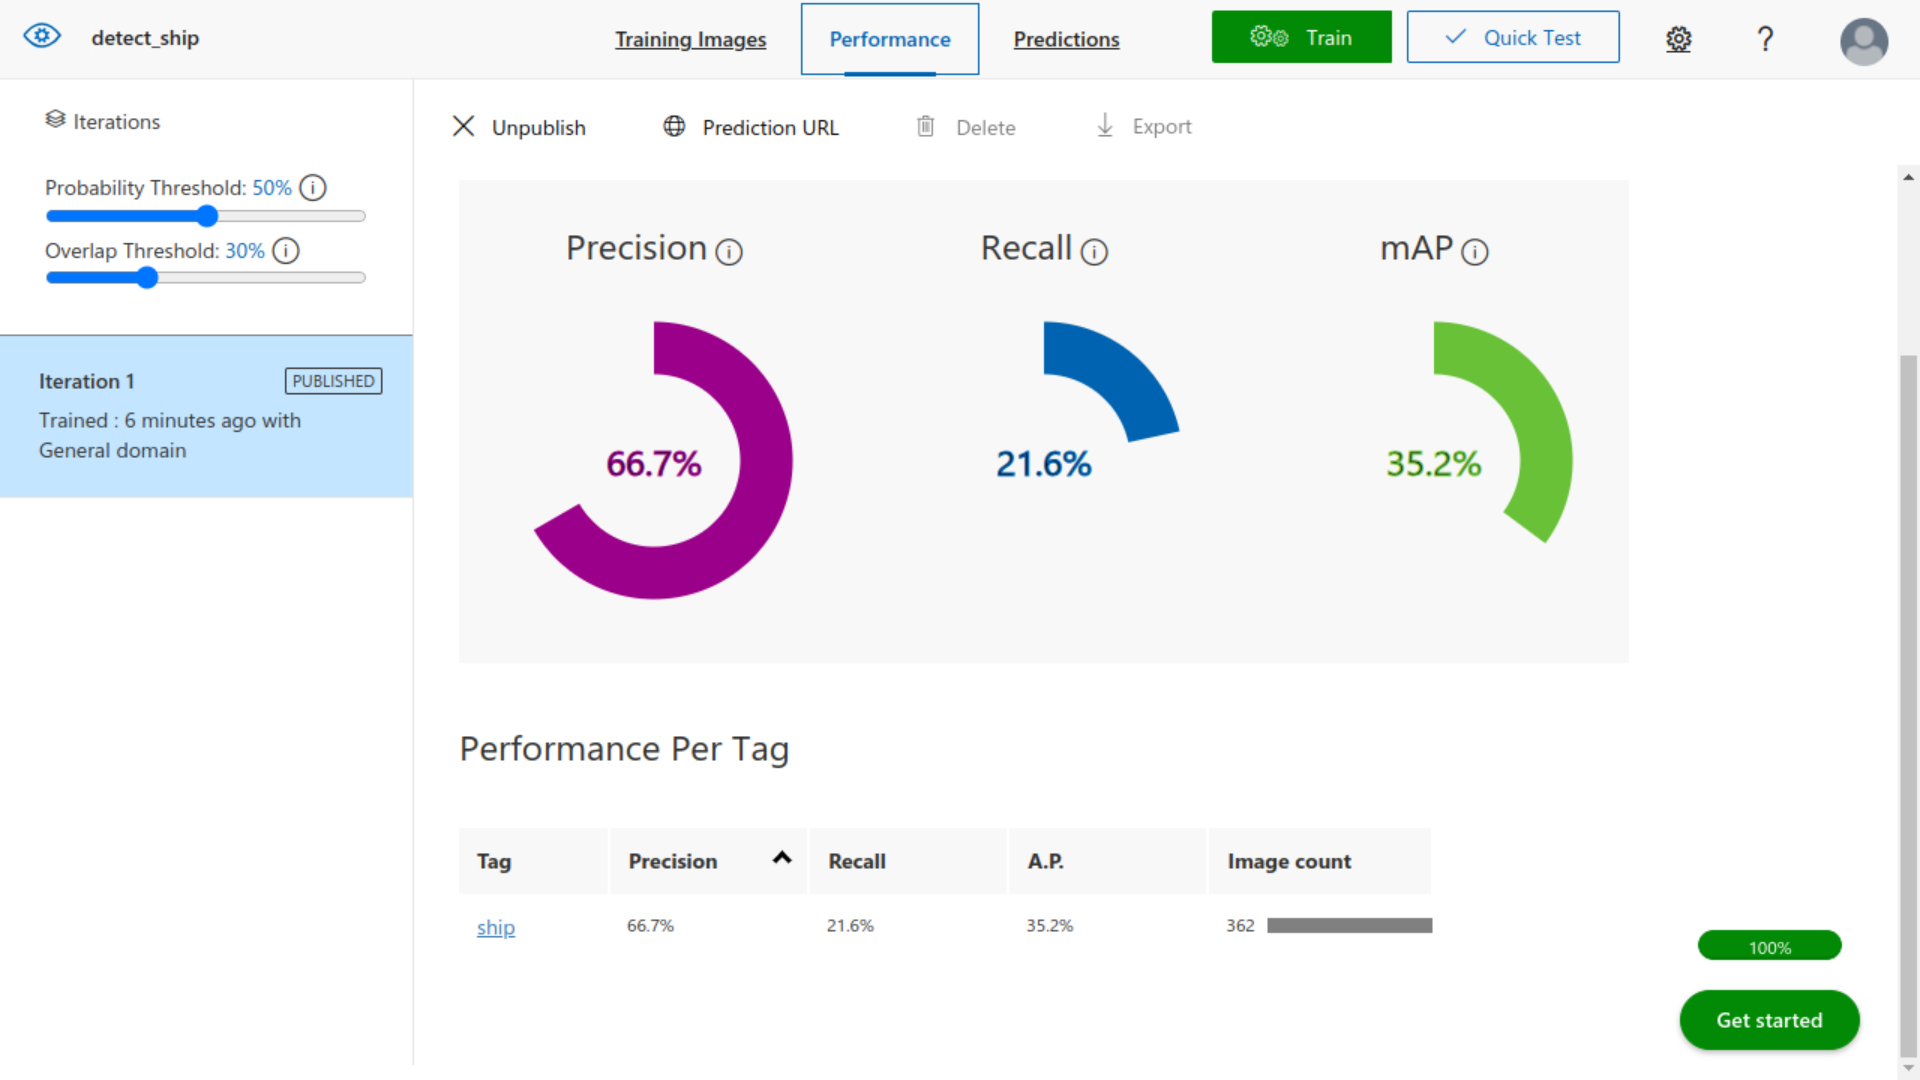

In [ ]:
img('cv13.png')

## You can view the predictions made, by clicking on the tag name under the section 'Performance per tag'. Click on an image to see the predictions, along with the confidence and bounding box.



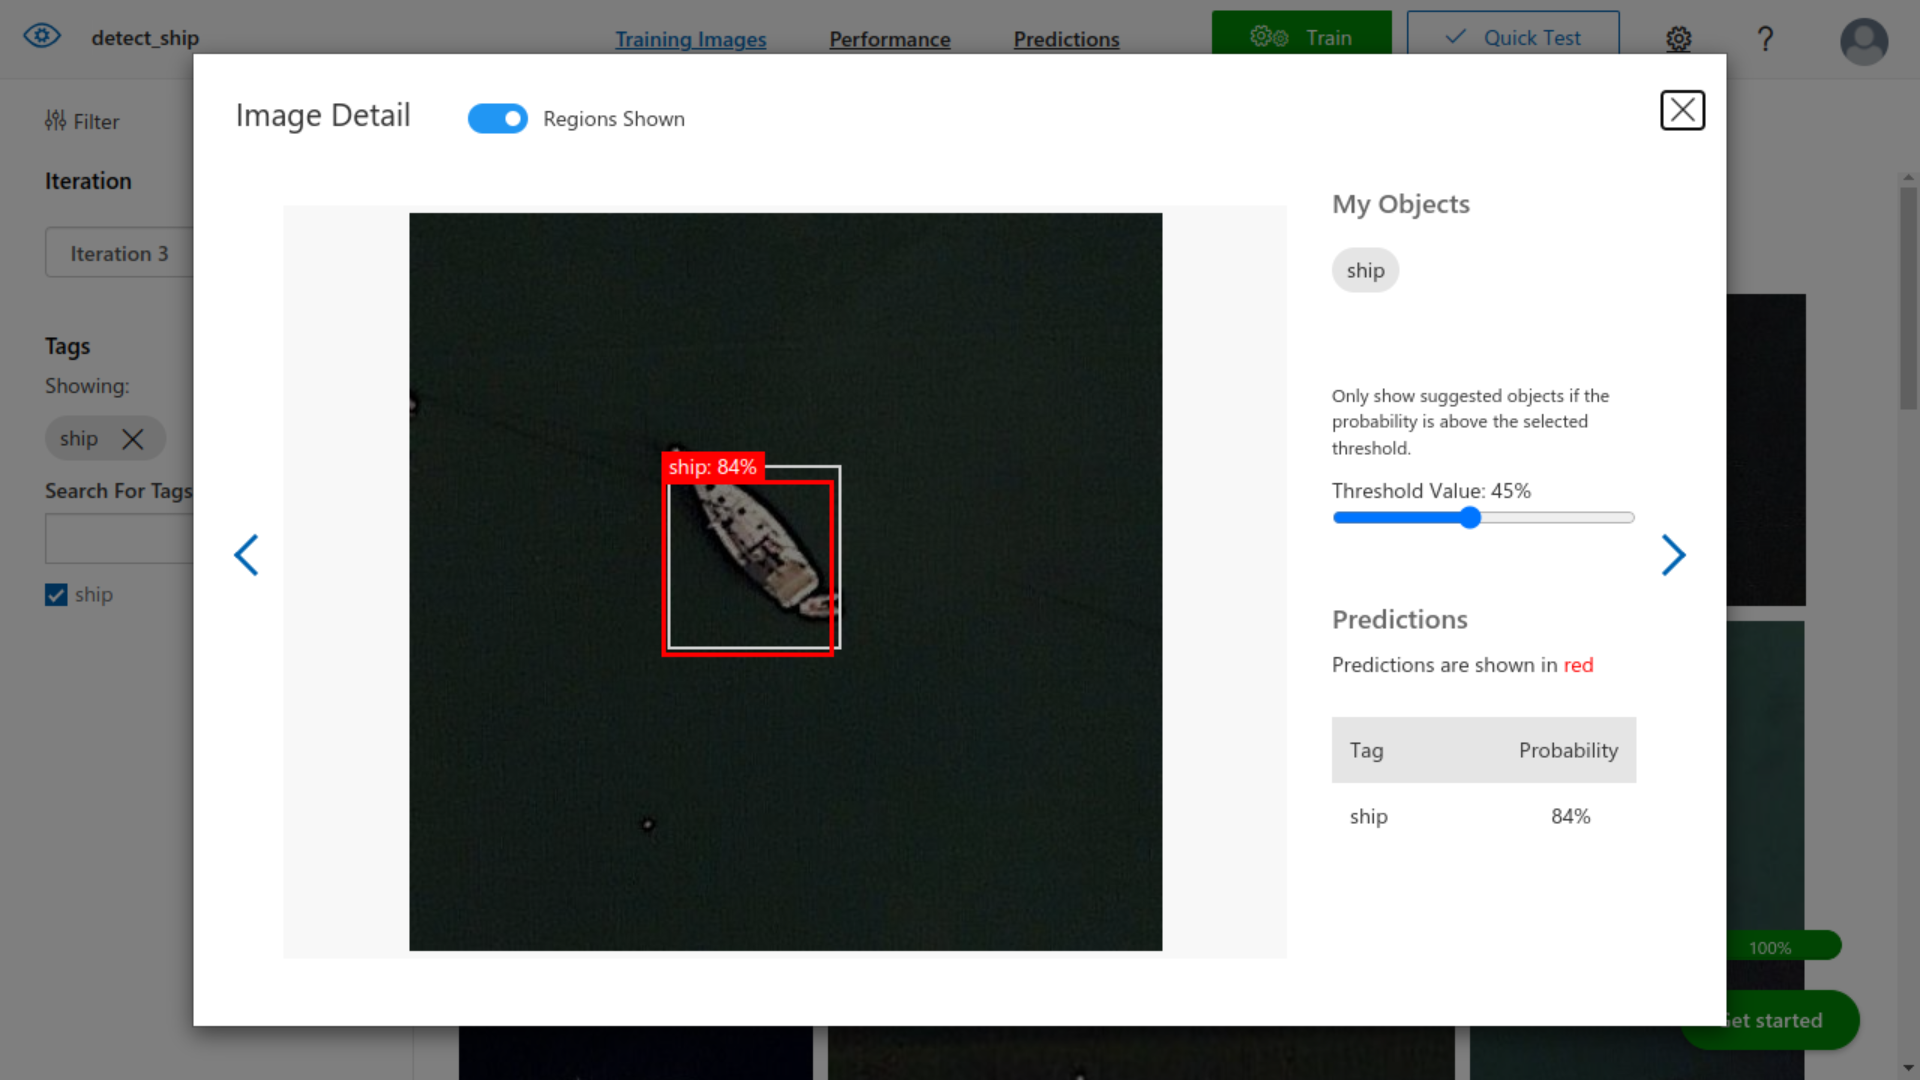

In [4]:
img('cv14.png')

##Inference: This model has a precision of 66.7%, recall of 21.6% and mean Average Precision of 35.2%. We need to understand how to interpret these values, and how can the model be improved.

-----

# Understanding the performance metrics:
## 1. Precision
## 2. Recall
## 3. Mean Average Precision (mAP)

![Mean Average Precision](https://a.storyblok.com/f/139616/1200x800/e3195e34f1/map-elements.webp)
https://a.storyblok.com/f/139616/1200x800/e3195e34f1/map-elements.webp

## Intersection over Union

**Intersection over Union (IoU)** is used to measure the accuracy of the localization provided by an object detector on a particular dataset. It does this by using the ground truth box and measures how much the predicted bounding box coordinates overlap the ground truth box coordinates.

![IoU](https://www.kdnuggets.com/wp-content/uploads/wadawadagi-object-detector-metrics-1.jpg)

https://www.kdnuggets.com/wp-content/uploads/wadawadagi-object-detector-metrics-1.jpg

For object detection tasks, we calculate precision and recall using the IoU value for a given IoU threshold.

For example, if the IoU threshold is 0.5, and the IoU value for a prediction is 0.7, then we classify the prediction as true positive (TP). On the other hand, if the IoU is 0.3, we classify it as False Positive (FP).

## Precision

**Precision** measures how accurate your predictions are. i.e. the percentage of your predictions that are correct.

It measures how many of the predictions that your model made were actually correct.

### Precision = true positives / (true positives + false positives)

TP = true positives (predicted as positive and was found to be correct)<br>
FP = false positives (predicted as positive but was found to be incorrect)


## Recall

**Recall** measures how well you find all the positives.

### Recall = true positives / (true positives + false negatives)

TP = true positives (predicted as positive and found to be correct)<br>
FN = false negatives (failed to predict an object that was there)


#### Precision, also referred to as the positive predictive value, describes how well a model predicts the positive class.  Whereas, Recall is about quantity and measures your model's ability to be able to find true positives out of all predictions. Recall, also called sensitivity tells you if your model made the right predictions when it should have.

![Metrics for object detection.](https://labelyourdata.com/img/article-illustrations/key_object_detection.jpg)  <https://labelyourdata.com/img/article-illustrations/key_object_detection.jpg/>


## Mean Average Precision (mAP)

The mean Average Precision uses the ground-truth bounding box, compares it to the detected box, and returns a score. The higher the mAP score, the more accurate the model detects and makes correct predictions.

## Compute Mean Average Precision
It is calculated by finding the Average Precision (AP) for each class and then the average over several classes. To calculate the AP, you will need to follow these steps:

1. Generate the prediction scores.

2. Convert the prediction scores into class labels.

3. Calculate the 4 attributes of the confusion matrix.

4. Calculate the precision and recall metrics.

5. Calculate the area under the precision-recall curve.

6. Measure the average precision.

The formula for mAP essentially tells us that, for a given class, k, we need to calculate its corresponding AP. The mean of these collated AP scores will produce the mAP and inform us how well the model performs.

![mAP](https://a.storyblok.com/f/139616/1200x800/09681b30bf/map-formula.webp)https://a.storyblok.com/f/139616/1200x800/09681b30bf/map-formula.webp

The concept of precision at K used in the calculation of mAP (AP @ K) stands for the Mean Average Precision at K. It is used to evaluate if the predicted items are relevant and if the most relevant items are at the top. The number of correctly labeled predicted labels is calculated, where K represents the top K labels that are considered.

Therefore, the Average Precision at K is the sum of the precision at K of the values of K divided by the total number of relevant items in the top K results. If we were to calculate the mean average precision at K, we measure the Average Precision at K averaged over all queries (entire dataset).

----

## You can retrain the model by taking a new slice of the training data.

### Publish the iteration once you are satisfied with the performance of the model.
### In case of multiple iterations, select the iteration that gives you the best performance, by saving the iteration id. Then, you can use this iteration ID to publish the model.

In [ ]:
# saving the best iteration
iteration.id = 'c1ef203d-e92b-4b79-90a5-17094cc8309b'

In [ ]:
# The iteration is now trained. Publish it to the project endpoint
trainer.publish_iteration(project.id, iteration.id, publish_iteration_name, prediction_resource_id)
print ("Done!")

Done!


## Test the model. Make a prediction by sending a test image.

In [ ]:
# Now there is a trained endpoint that can be used to make a prediction
# Open the sample image and get back the prediction results.
with open('/content/test_images/boat74.png',
            mode="rb") as test_data:
  results = predictor.detect_image(project.id, publish_iteration_name,
                                    test_data)

# Display the results.
for prediction in results.predictions:
  print("\t" + prediction.tag_name + ": {0:.2f}% bbox.left = {1:.2f}, bbox.top = {2:.2f}, bbox.width = {3:.2f}, bbox.height = {4:.2f}".format(
          prediction.probability * 100, prediction.bounding_box.left,
          prediction.bounding_box.top, prediction.bounding_box.width,
          prediction.bounding_box.height))

	ship: 82.90% bbox.left = 0.21, bbox.top = 0.32, bbox.width = 0.25, bbox.height = 0.19
	ship: 2.71% bbox.left = 0.35, bbox.top = 0.32, bbox.width = 0.07, bbox.height = 0.07
	ship: 2.52% bbox.left = 0.59, bbox.top = 0.56, bbox.width = 0.07, bbox.height = 0.07
	ship: 1.87% bbox.left = 0.30, bbox.top = 0.47, bbox.width = 0.17, bbox.height = 0.23
	ship: 1.38% bbox.left = 0.23, bbox.top = 0.61, bbox.width = 0.06, bbox.height = 0.08
	ship: 1.26% bbox.left = 0.22, bbox.top = 0.09, bbox.width = 0.21, bbox.height = 0.26
	ship: 1.24% bbox.left = 0.29, bbox.top = 0.37, bbox.width = 0.06, bbox.height = 0.07
	ship: 1.08% bbox.left = 0.34, bbox.top = 0.09, bbox.width = 0.20, bbox.height = 0.26
	ship: 1.07% bbox.left = 0.81, bbox.top = 0.78, bbox.width = 0.19, bbox.height = 0.22
	ship: 1.06% bbox.left = 0.24, bbox.top = 0.37, bbox.width = 0.06, bbox.height = 0.06
	ship: 1.01% bbox.left = 0.59, bbox.top = 0.37, bbox.width = 0.06, bbox.height = 0.07
	ship: 0.97% bbox.left = 0.46, bbox.top = 0.30, bbox.

## Viewing the bounding box in the image.
### Of all the predictions made, we will only show the bounding box for which the confidence exceeds a certain threshold, say 50%.

In [ ]:
# Load a test image and get its dimensions
img_file = '/content/test_images/boat74.png'
my_img = Image.open(img_file)
img_height, img_width, img_ch = np.array(my_img).shape

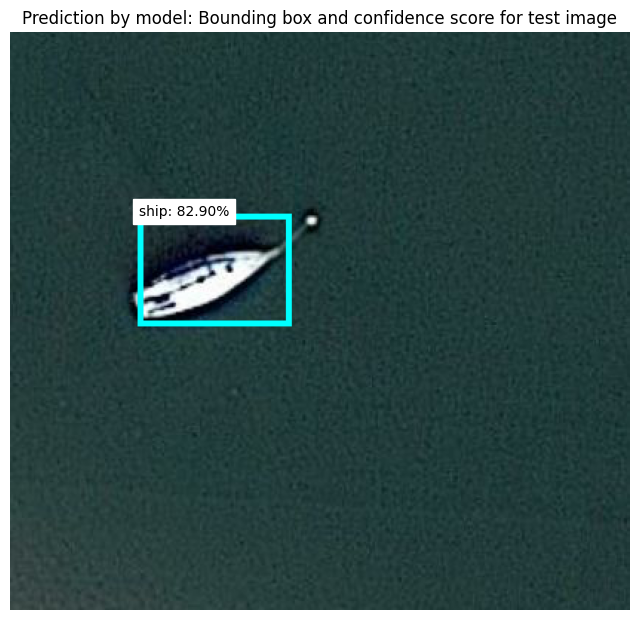

In [ ]:
# Create a figure to display the results
fig = plt.figure(figsize=(8, 8))
plt.axis('off')
# Display the image
draw = ImageDraw.Draw(my_img)
# Select line width and color for the bounding box
lineWidth = int(img_width/100)
prediction_color = 'cyan'
# Display the results
for prediction in results.predictions:
    color = 'white' # default
    if (prediction.probability*100) > 50:
        left = prediction.bounding_box.left * img_width
        top = prediction.bounding_box.top * img_height
        height = prediction.bounding_box.height * img_height
        width =  prediction.bounding_box.width * img_width
        # Create a rectangle
        draw.rectangle((left, top, left+width, top+height), outline=prediction_color, width=lineWidth)
        # Display tags and probabilities
        plt.annotate(f"{prediction.tag_name}: {prediction.probability * 100 :.2f}%",(left,top), backgroundcolor=color)
plt.imshow(my_img)
plt.title("Prediction by model: Bounding box and confidence score for test image")
plt.show()

## How to improve the model?

The following is a general pattern to help you train a more accurate model:

First-round training
Add more images and balance data; retrain
Add images with varying background, lighting, object size, camera angle, and style; retrain
Use new image(s) to test prediction
Modify existing training data according to prediction results

Reference: https://learn.microsoft.com/en-us/azure/ai-services/custom-vision-service/getting-started-improving-your-classifier

## Close the project - resource deletion

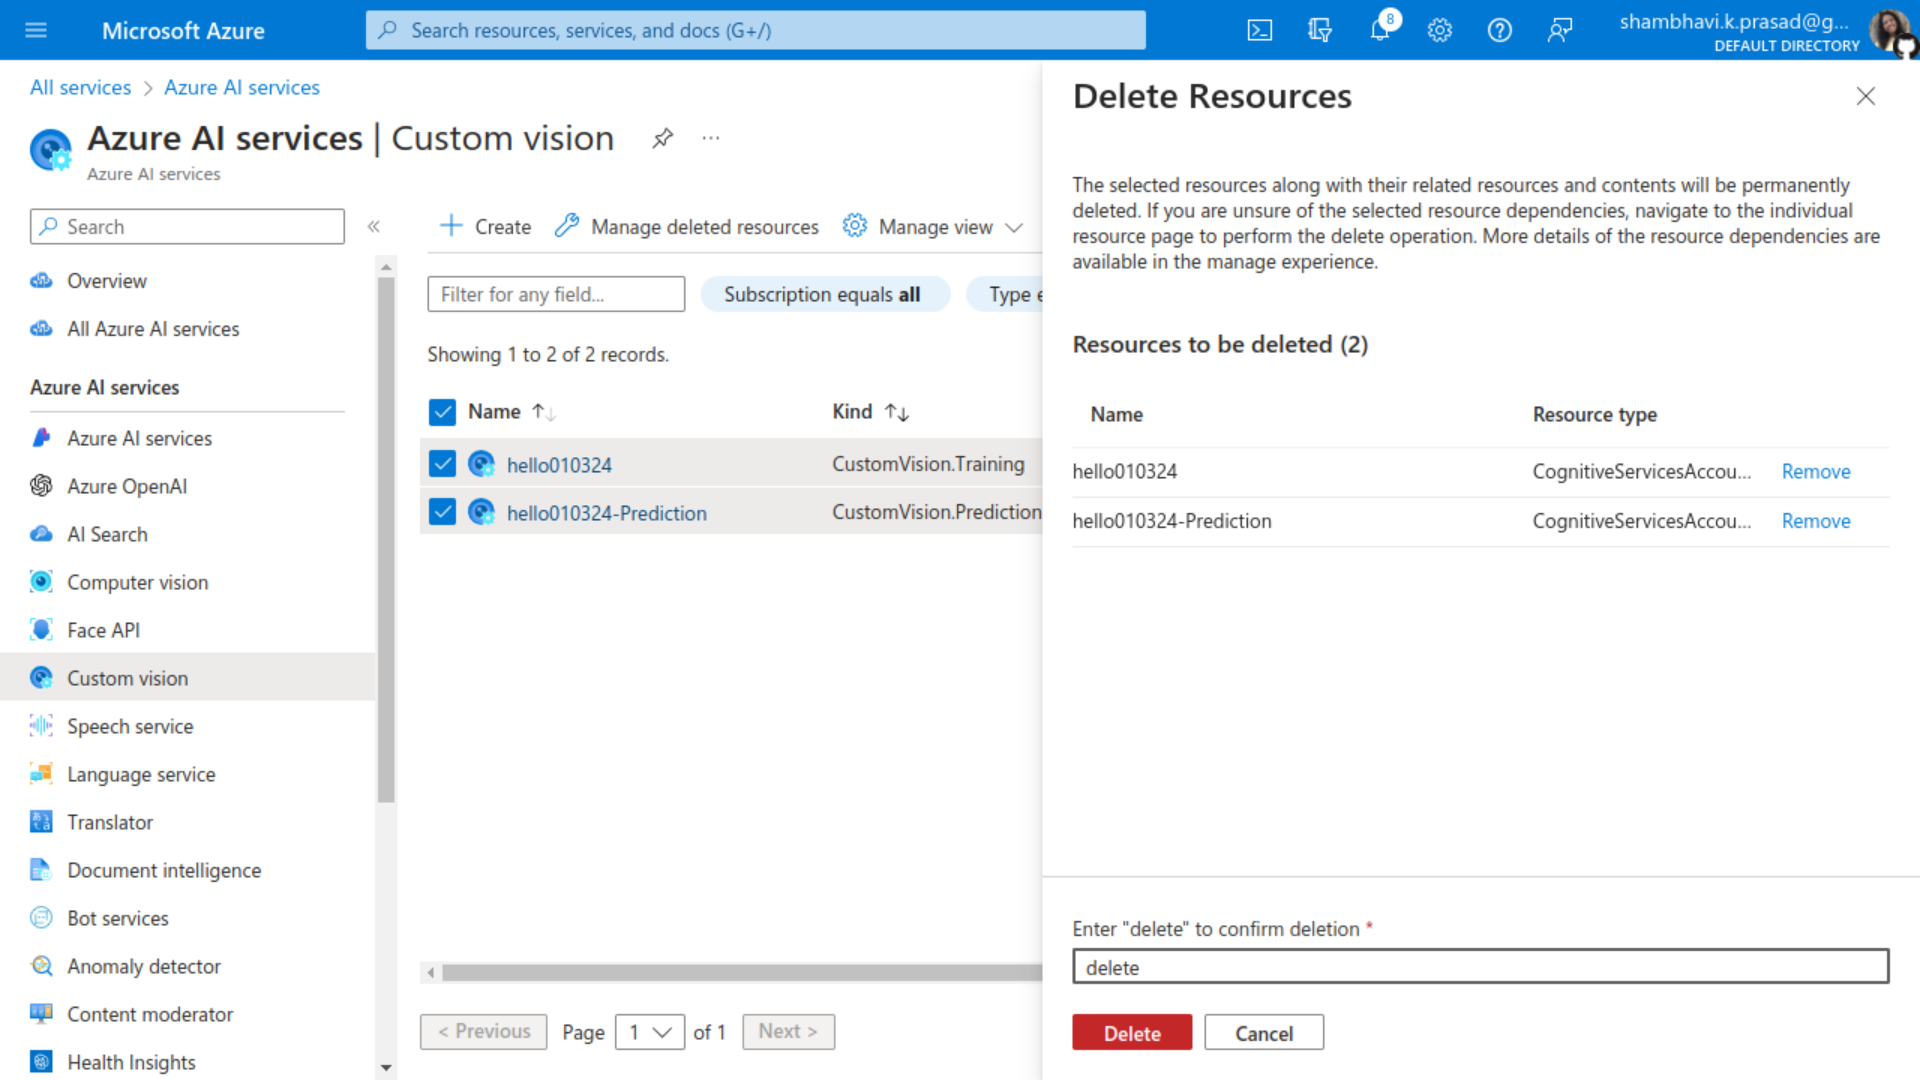

In [ ]:
img('cv16.png')

----

## Useful links:
https://kili-technology.com/data-labeling/machine-learning/mean-average-precision-map-a-complete-guide

https://xailient.com/blog/what-is-mean-average-precision-and-how-does-it-work

https://www.kdnuggets.com/2020/08/metrics-evaluate-deep-learning-object-detectors.html

https://blog.paperspace.com/mean-average-precision/

https://learn.microsoft.com/en-us/azure/ai-services/custom-vision-service/getting-started-improving-your-classifier